In [1]:
import os
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Définir les répertoires
base_dir = '/content/drive/My Drive/Colab Notebooks/Presentation20062024'
annotation_dir = os.path.join(base_dir, 'ANNOTATION_ANNOTATEURICES/CF_Annotations')
gold_dir = os.path.join(base_dir, 'ANNOTATION_ADJUDICATION/GOLD_interpretatif')
accord_dir = os.path.join(base_dir, 'ANNOTATION_ADJUDICATION/ACCORD_MAJtr')
output_gold_dir = os.path.join(base_dir, 'ANNOTATION_ADJUDICATION/Camemberts-Gold')
output_accord_dir = os.path.join(base_dir, 'ANNOTATION_ADJUDICATION/Camemberts-Accord')

max_tokens = 6500

# Création des dossiers de sortie s'ils n'existent pas
if not os.path.exists(output_gold_dir):
    os.makedirs(output_gold_dir)

if not os.path.exists(output_accord_dir):
    os.makedirs(output_accord_dir)

Processing resultat_Adjudication_DAUDET_petit-chose_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv


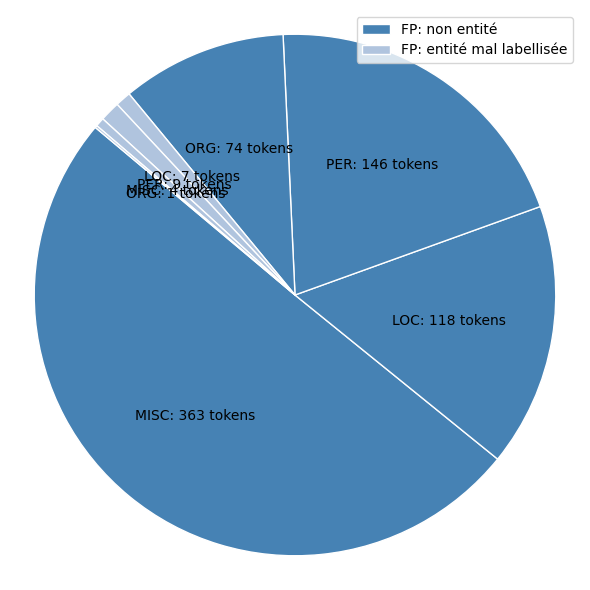

Processing resultat_Adjudication_DAUDET_petit-chose_REF_spaCy3.7.2-lg.csv.aia.csv


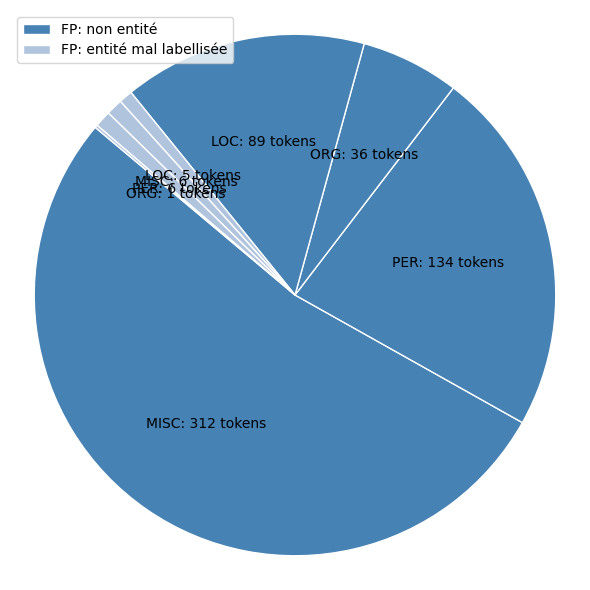

Processing resultat_Adjudication_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv


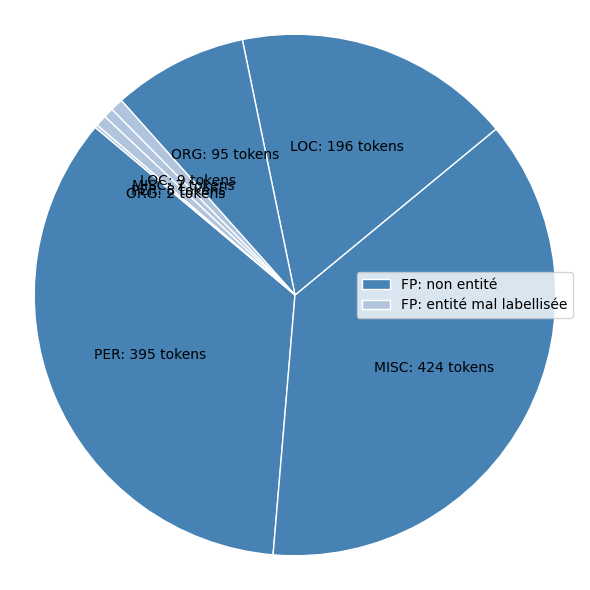

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv


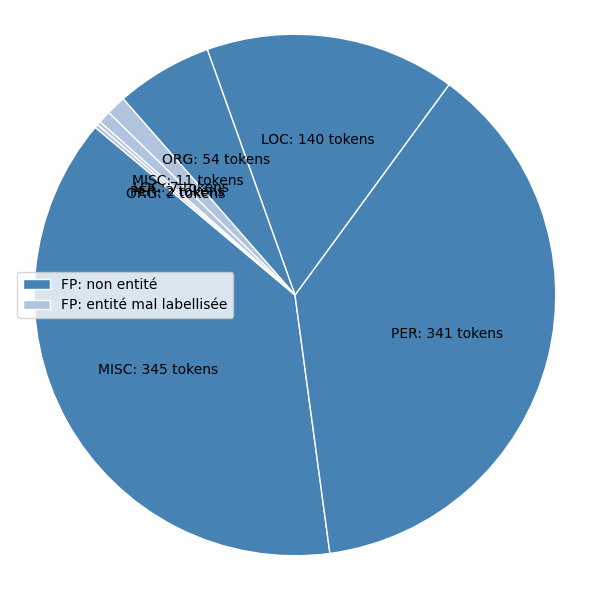

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv


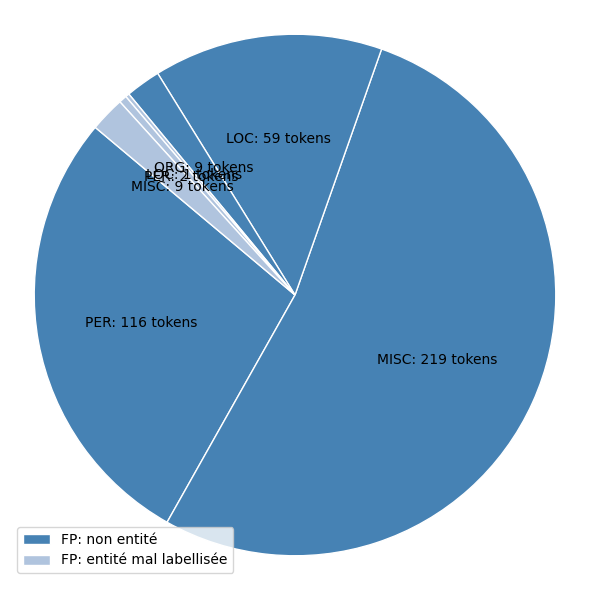

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv


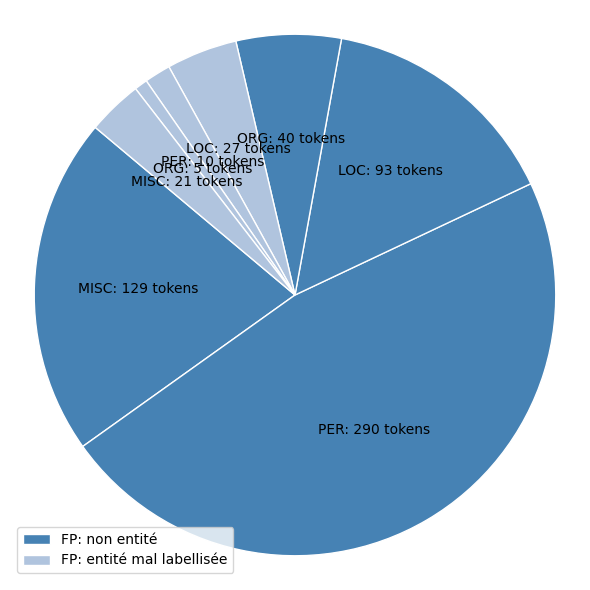

Processing resultat_Adjudication_DAUDET_petit-chose_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv


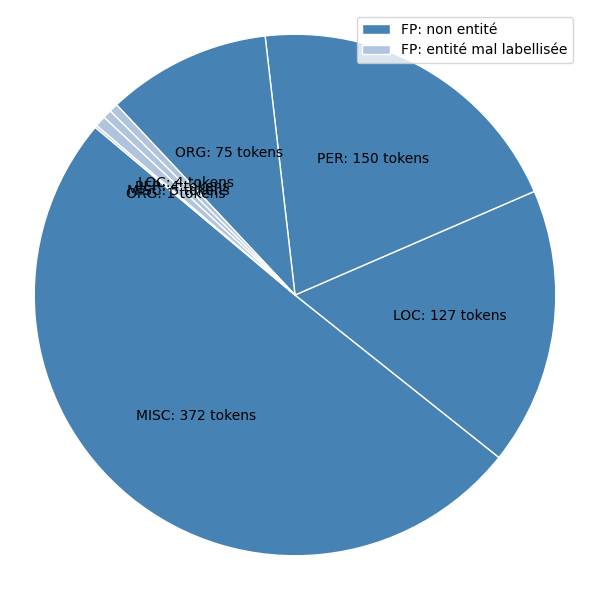

Processing resultat_Adjudication_DAUDET_petit-chose_REF_spaCy3.7.2-lg.csv.aia.csv


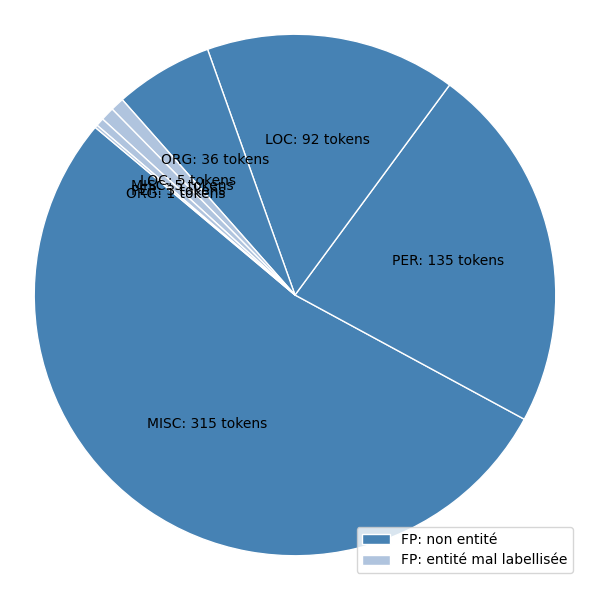

Processing resultat_Adjudication_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv


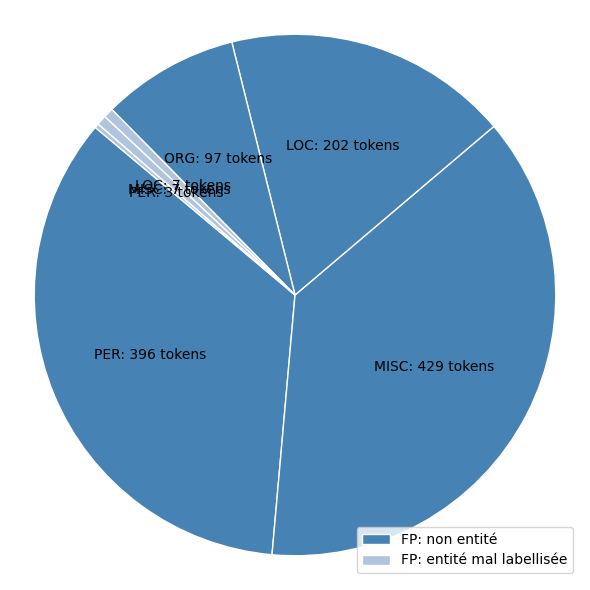

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv


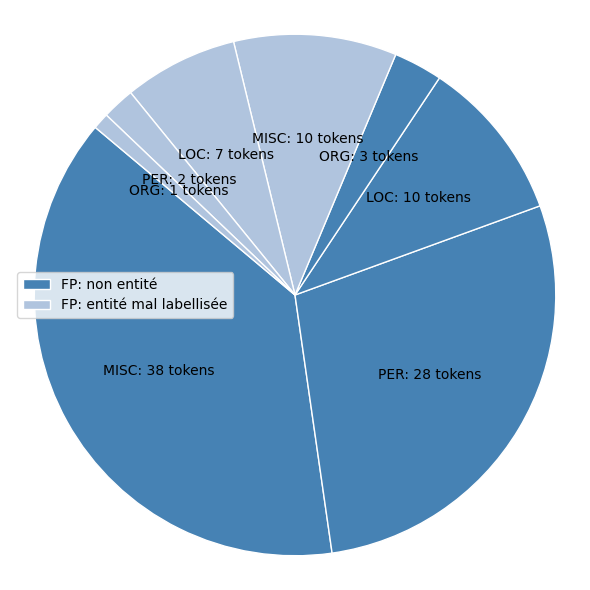

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv


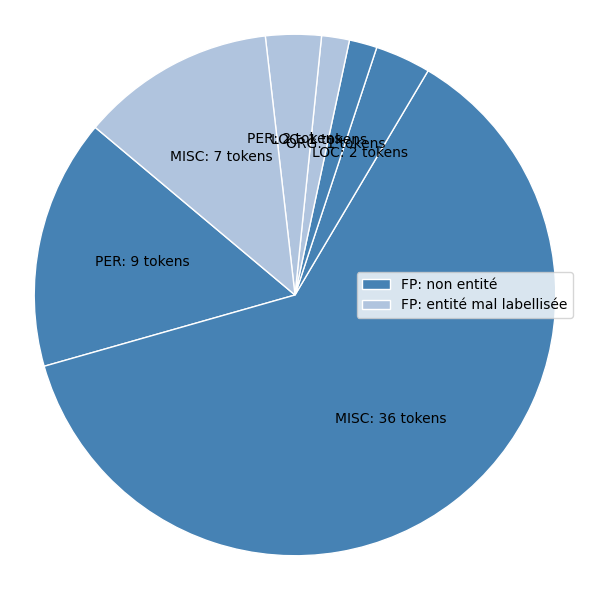

Processing resultat_Adjudication_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv


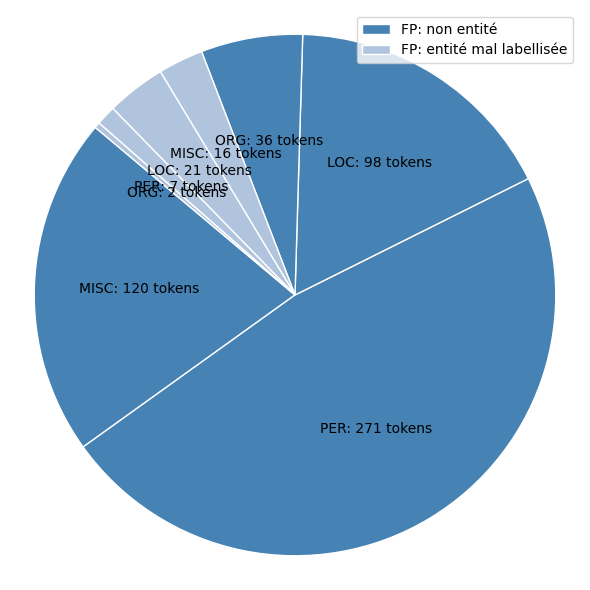

In [11]:
# Initialiser les compteurs globaux
def init_counters():
    return {
        'fp_na_count': 0,
        'fp_label_error_count': 0,
        'fp_na_labels': {},
        'fp_label_error_labels': {},
        'token_count': 0,  # Ajouter un compteur de tokens
        'tokens_fp': 0,
        'tokens_fp_na': {},
        'tokens_fp_label_error': {}
    }

# Fonction pour traiter chaque fichier CSV
def process_csv_file(file_path_annot, file_path_compare, counters, compare_column, max_tokens=6500):
    unique_annotations = set()

    with open(file_path_annot, 'r', encoding='utf-8') as file_annot, open(file_path_compare, 'r', encoding='utf-8') as file_comp:
        reader_annot = csv.DictReader(file_annot, delimiter=';')
        reader_comp = csv.DictReader(file_comp, delimiter=';')

        for row_annot, row_comp in zip(reader_annot, reader_comp):
            if counters['token_count'] >= max_tokens:
                return

            token = row_annot['Token']
            label = row_annot['Label']
            compare_label = row_comp[compare_column]

            # Créer une clé unique pour chaque annotation
            annotation_key = (token, label, compare_label)

            if annotation_key not in unique_annotations:
                unique_annotations.add(annotation_key)
                counters['token_count'] += 1

                if label:
                    if not compare_label:
                        # Faux positif: non entité
                        counters['fp_na_count'] += 1
                        counters['tokens_fp'] += 1
                        if label in counters['fp_na_labels']:
                            counters['fp_na_labels'][label] += 1
                            counters['tokens_fp_na'][label] += 1
                        else:
                            counters['fp_na_labels'][label] = 1
                            counters['tokens_fp_na'][label] = 1
                    elif label != compare_label:
                        # Faux positif: entité mal labellisée
                        counters['fp_label_error_count'] += 1
                        counters['tokens_fp'] += 1
                        if label in counters['fp_label_error_labels']:
                            counters['fp_label_error_labels'][label] += 1
                            counters['tokens_fp_label_error'][label] += 1
                        else:
                            counters['fp_label_error_labels'][label] = 1
                            counters['tokens_fp_label_error'][label] = 1

# Fonction pour créer un camembert des FP
def create_fp_pie_chart(counters, output_path):
    total_fp = counters['fp_na_count'] + counters['fp_label_error_count']
    if total_fp == 0:
        print(f"No false positives to display for {output_path}")
        return

    labels_fp = list(counters['fp_na_labels'].keys()) + list(counters['fp_label_error_labels'].keys())
    sizes_fp = list(counters['fp_na_labels'].values()) + list(counters['fp_label_error_labels'].values())
    colors_fp = ['#4682B4'] * len(counters['fp_na_labels']) + ['#B0C4DE'] * len(counters['fp_label_error_labels'])

    # Création du camembert
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes_fp, startangle=140, colors=colors_fp, wedgeprops=dict(edgecolor='w'), autopct='%1.1f%%')

    # Ajout des annotations pour les labels initiaux
    for i, label in enumerate(labels_fp):
        autotexts[i].set_text(f'{label}: {sizes_fp[i]} tokens')

    # Ajout de la légende
    legend_labels = ['FP: non entité', 'FP: entité mal labellisée']
    ax.legend([wedges[0], wedges[len(counters['fp_na_labels'])]], legend_labels, loc="best")
    ax.axis('equal')

    # Enregistrer le camembert
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


# Fonction principale pour traiter les dossiers
def process_directory(annotation_dir, compare_dir, output_dir, compare_column, file_map):
    for compare_filename, annot_filename in file_map.items():
        annot_subfolder = "DAUDET" if "DAUDET" in compare_filename else "CARRAUD"
        compare_subfolder = annot_subfolder

        file_path_annot = os.path.join(annotation_dir, annot_subfolder, annot_filename)
        file_path_compare = os.path.join(compare_dir, compare_subfolder, compare_filename)
        output_path_fp = os.path.join(output_dir, f'{compare_filename[:-4]}_fp_pie_chart.png')

        if os.path.exists(file_path_annot) and os.path.exists(file_path_compare):
            print(f"Processing {compare_filename}")
            counters = init_counters()
            process_csv_file(file_path_annot, file_path_compare, counters, compare_column, max_tokens)
            create_fp_pie_chart(counters, output_path_fp)
        else:
            if not os.path.exists(file_path_annot):
                print(f"Annotation file {file_path_annot} does not exist")
            if not os.path.exists(file_path_compare):
                print(f"Comparison file {file_path_compare} does not exist")

# Map des fichiers de comparaison vers les fichiers d'annotation
file_map = {
    "resultat_Adjudication_DAUDET_petit-chose_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv": "CF_DAUDET_petit-chose_TesseractFra-PNG_spaCy3.7.2-lg.csv",
    "resultat_Adjudication_DAUDET_petit-chose_REF_spaCy3.7.2-lg.csv.aia.csv": "CF_DAUDET_petit-chose_REF_spaCy3.7.2-lg.csv",
    "resultat_Adjudication_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv": "CF_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv",
    "resultat_Adjudication_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv": "CF_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv",
    "resultat_Adjudication_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv": "CF_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv",
    "resultat_Adjudication_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv": "CF_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv"
}

# Traiter les dossiers gold et accord
process_directory(annotation_dir, gold_dir, output_gold_dir, 'gold', file_map)
process_directory(annotation_dir, accord_dir, output_accord_dir, 'accord', file_map)